## Crash Course — Python & Pandas for Trading and Investing (Part 1)

* Link: https://mitchellrosenthalofficial.medium.com/crash-course-python-pandas-for-trading-and-investing-part-1-714b77dfdc21
* Summary/Findings: Helpful for imports, creating time series and using moving average to create signals and evaluate returns on investment.

This case study uses random number generation for stock prices instead of a real one. 

<h2>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
import scipy.stats as stats
import re
from datetime import datetime
from datetime import date
import random
import seaborn as sns
sns.set()

To prevent outputs from being truncated, set all the display settings to None. 

In [28]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Generate an index of desired time period 

In [29]:
our_index = pd.date_range(start='2020-12-21', periods=2500, freq='D')
df = pd.DataFrame(index = our_index)

Generate the closing value of stocks for desired time period with the following steps:
1. Fill a column with random, small decimal numbers. They represent the logarithm of the daily changes in the stock price, and we’ll sample them from a random distribution.
2. Replace each number (N) with e^N, so our column will be filled with values near 1 (like 0.99, 1.01, 0.97, etc.). These values represent 1 plus the % change experienced that day.
3. Set the first row equal to 1, which is our starting stock price.
4. Take the cumulative product of the column.

In [30]:
df['Close'] = np.random.normal(loc=0.0002, scale=0.011, size=2500)
df['Close'] = np.exp(df['Close'])
df['Close'].iloc[0] = 1
df['Close'] = df['Close'].cumprod()

<AxesSubplot:title={'center':'Our Fake Stock Price'}>

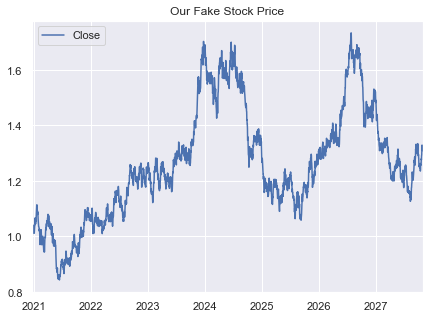

In [31]:
df[['Close']].plot(figsize=(7,5), title='Our Fake Stock Price')

Caclulate moving average by taking the rolling mean over the past 100 days.

<AxesSubplot:title={'center':'Our Fake Stock Price'}>

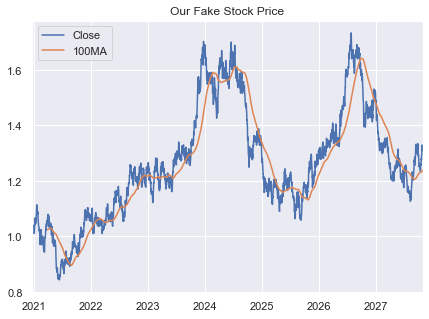

In [32]:
df['100MA'] = df['Close'].rolling(100).mean()
df[['Close','100MA']].plot(figsize=(7,5), title='Our Fake Stock Price')

Create a column that holds the distance between the moving average and closing price of the stock each day. 

In [ ]:
df['100MAdist'] = -1 + (df['Close'] / df['100MA'])

Make multiple plots at once where the first column in subplot represents rows and the second represents the number of coloumns in our figure. The last value represents which plot number the subplot is. 

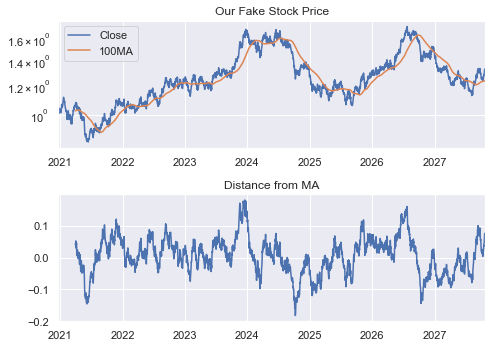

In [33]:
f1 = plt.figure(figsize=(7,5))
ax1 = f1.add_subplot(2, 1, 1)
ax2 = f1.add_subplot(2, 1, 2)

df[['Close','100MA']].plot(title='Our Fake Stock Price', ax=ax1, logy=True)
df['100MAdist'].plot(title='Distance from MA', ax=ax2)
plt.tight_layout()

Next, we create a signal based on the moving average. We do this by adding two coloumns, true and false that only store values when the conditional of closing value of the stock price being greater than the movng average price is either true or false. 

The signal exists to indicate that if closing price is above 100 days of moving average then we want to hold onto the stock. 

In [34]:
df['SignalTrue'] = np.where(df['Close']>df['100MA'], df['Close'], np.NaN)
df['SignalFalse'] = np.where(df['Close']>df['100MA'], np.NaN, df['Close'])

<AxesSubplot:title={'center':'Our Fake Stock Price'}>

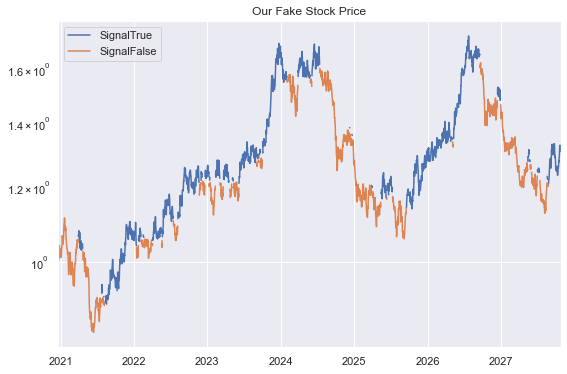

In [35]:
f1 = plt.figure(figsize=(9,6))
ax1 = f1.add_subplot(1, 1, 1)
df[['SignalTrue','SignalFalse']].plot(title='Our Fake Stock Price', ax=ax1, logy=True)

Now that we have learnt how to visualize and build trading signal, lets actually work on using it as a trading strategy and evaluating returns from its application.

First, generate an index with the desired time period again with 30 minute increments to generate the OHLC data. (Open,High,Low,Close prices) 

In [36]:
our_index = pd.date_range(start='2020-12-21', periods=2500*24*2, freq='30T')
df = pd.DataFrame(index = our_index)

**Next, we find new mean and standard deviation values. since each day has 48 30 minute increments, we use the following formulas to update mean and stnadard deviation**

**Mean**
* (1+R)⁴⁸ = (1+r)¹
* (1+R) = (1+r)^(1/48)
* R = [(1+r)^(1/48)]-1

**Stdev**
* (STDEV)/(sqrt(1/48)) = (stdev)/(sqrt(1))
* STDEV = (stdev)(sqrt(1))(sqrt(1/48))

In [ ]:
R_old = 0.0002
Stdev_old = 0.011
R_new = (1+R_old)**(1/48)-1
Stdev_new = (Stdev_old)*(1**0.5)*((1/48)**0.5)

We then generate the closing price the same we did previously by generasting random numbers that follow normal distirbution then taking their logarithmic value.

<AxesSubplot:>

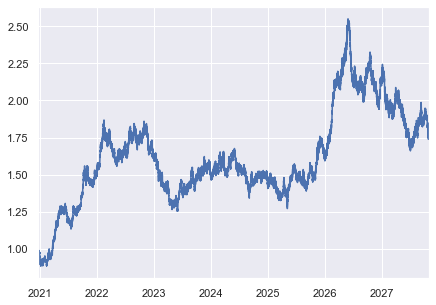

In [37]:
df['Close'] = np.random.normal(loc=R_new, scale=Stdev_new, size=2500*24*2)
df['Close'] = np.exp(df['Close'])
df['Close'].iloc[0] = 1
df['Close'] = df['Close'].cumprod()
df['Close'].plot(figsize=(7,5))

Now we filter the DataFrame, keeping times when the market is open. Then, we will use resample(‘1D’).ohlc() to get the open, high, low, and close values of each day in our filtered DataFrame. 

In [38]:
df = df.between_time('09:30', '16:00')
df = df['Close'].resample('1D').ohlc()
df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close'}, inplace=True)
df.head()

,Open,High,Low,Close
2020-12-21,0.983535,0.986711,0.982862,0.983908
2020-12-22,0.984754,0.984754,0.974854,0.974854
2020-12-23,0.982171,0.985504,0.976863,0.977266
2020-12-24,0.975480,0.984354,0.975277,0.976338
2020-12-25,0.975230,0.985185,0.975230,0.985027


**Testing the Strategy**

For any given day, there are four potential % changes our portfolio might experience:

* If the signal equaled 1 at the end of yesterday’s close, and 0 the day before, then today we buy at the open. Today, we experience the change from the open to the close.
* If the signal equaled 1 at the end of yesterday’s close and the day before, we continue to hold through today. We experience the change from yesterday’s close to today’s close.
* If the signal equaled 0 at the end of yesterday’s close and 1 the day before, then today we exit (sell) at the open. Today, we experience the change from yesterday’s close to today’s open. This is the overnight change.
* If the signal equaled 0 at the end of yesterday’s close and 0 the day before, we do nothing today and experience no change. This is our default setting.

First, we create our three main conditions, one for buying, one for holding, and one for selling.

In [39]:
df['100MA'] = df['Close'].rolling(100).mean()
df['MAsignal'] = np.where(df['Close']>df['100MA'], 1, 0)

condition1 = (df['MAsignal'].shift(1)==1) & (df['MAsignal'].shift(2)==0)
condition2 = (df['MAsignal'].shift(1)==1) & (df['MAsignal'].shift(2)==1)
condition3 = (df['MAsignal'].shift(1)==0) & (df['MAsignal'].shift(2)==1)

Next, we create a column of the daily changes experienced by our portfolio when betting on this strategy. 

In [40]:
df['PortChng'] = 0 # default setting
df['PortChng'] = np.where(condition1, -1 + df['Close']/df['Open'], df['PortChng'])
df['PortChng'] = np.where(condition2, -1 + df['Close']/df['Close'].shift(1), df['PortChng'])
df['PortChng'] = np.where(condition3, -1 + df['Open']/df['Close'].shift(1), df['PortChng'])

In [ ]:
Finally, we have a coloumn that tracks the changes to our portfolio and takes the cummulative product.

In [41]:
df['Port'] = df['PortChng'] + 1
df['Port'] = df['Port'].cumprod()

Now we can plot this and compare it to just being in the stock price the whole time. For further visualizations, we use the true_indexvals variable and a for loop tp generate green lines whenever the stock market is open. Or, in other words, whenever conditions 1,2 or 3 are satisfied. 

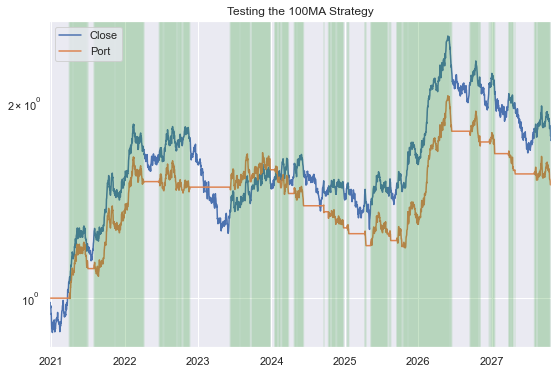

In [42]:
f1 = plt.figure(figsize=(9,6))
ax1 = f1.add_subplot(1, 1, 1)
true_indexvals = df[condition1|condition2|condition3].index.tolist()
df[['Close','Port']].plot(title='Testing the 100MA Strategy', ax=ax1, logy=True)
for x in true_indexvals:
  ax1.axvline(x, color='tab:green', alpha = 0.22, linewidth = .25, linestyle='-')
ax1.legend(loc='upper left')